In [1]:
%load_ext lab_black
%load_ext nb_black

import os
import sys
PATH = "/Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp" # os.environ['DF_ROOT']
sys.path.insert(1, PATH+"/commonFunctions/")

import lstmDevDependencies
import requests
import time
import copy
import warnings
import quandl
import pickle
import logging
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import dataFunctions as dataFun

import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import linear_model

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm._tqdm_notebook import tqdm_notebook

Using TensorFlow backend.


In [2]:
print(tf.__version__,
keras.__version__,
pd.__version__,
np.__version__,
sklearn.__version__,
sns.__version__,
matplotlib.__version__)


1.14.0 2.3.0 0.25.0 1.16.4 0.21.3 0.9.0 3.1.1


In [3]:
"""

GENERAL CONFIGURATIONS OF DATA ACQUISITION AND MODEL PARAMETERS

"""

'\n\nGENERAL CONFIGURATIONS OF DATA ACQUISITION AND MODEL PARAMETERS\n\n'

In [4]:

QAPIKEY                     = "YpAydSEsKoSAfuQ9UKhu"
quandl.ApiConfig.api_key    = QAPIKEY

# Cost parameters set by the task for running ship for one day
barrels         = 750000
costPerDay      = 30000
daysToPredict   = 1

# Data split for training and testing.
trainDataDate   = '2010-01-01'
testSplitDate   = '2019-11-26'

# Parameters for the model.
params = {
    "batch_size":   20,  # 20<16<10, 25 was a bust
    "epochs":       200,
    "lr":           0.0010000,
    "time_steps":   60
}

# Replace with Cloud path with data later on
PATH_TO_DRIVE_ML_DATA   = PATH
INPUT_PATH              = PATH_TO_DRIVE_ML_DATA+"/LSTM_dev/inputs/"
OUTPUT_PATH             = PATH_TO_DRIVE_ML_DATA+"/LSTM_dev/outputs/"
TIME_STEPS              = params["time_steps"]
BATCH_SIZE              = params["batch_size"]

# Some environmental parameters.
os.environ['TF_CPP_MIN_LOG_LEVEL']  = '2'
os.environ['TZ']                    = 'Europe/London'
time.tzset()
stime                               = time.time()

modDate         = dt.today().date()
dataDate        = modDate - td(days=1)
updateData      = False
is_update_model = True

dataFileName    = "inputData_" + str(dataDate) + ".csv"
modFileName     = "LSTM_" + str(modDate) + ".sav"

In [5]:
"""

CREATING RELEVANT DIRECTORIES FOR DEVELPOPMENT

"""

'\n\nCREATING RELEVANT DIRECTORIES FOR DEVELPOPMENT\n\n'

In [6]:
# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory "+OUTPUT_PATH+" already exists.")

if not os.path.exists(INPUT_PATH):
    os.makedirs(INPUT_PATH)
    print("Directory created", INPUT_PATH)
else:
    print("Directory "+INPUT_PATH+" already exists.")



Directory /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/outputs/ already exists.
Directory /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/inputs/ already exists.


In [7]:
"""
This is dataFunctions.py 
"""

from datetime import datetime as dt
import matplotlib.pyplot as plt
import requests
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import math as m
import pandas as pd
import urllib.request as ur
import urllib.error as ue
import shutil
import csv
import time
import os
import os.path
import sys

PATH = "/Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp" # os.environ['DF_ROOT']

sys.path.insert(1, PATH+"/commonFunctions/")
# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# os.chdir(dname)

def show_more(df, lines):
    with pd.option_context("display.max_rows", lines):
        display(df)

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


""" YAHOO FINANCE SECTION START """
###### SET PARAMETERS ######
# yf.pdr_override() #pandas datareader format


def yFinData(startDt, interval = "1d", endDt = -1, stock="CL=F", onlyClose = True, name="Prices"):
    today = dt.today().strftime('%Y-%m-%d')
    if endDt == -1:
        endDt = today
        
    stockInfo = yf.Ticker(stock).info
    
    ###### GET DATA #######
    Stocks = yf.download(stock, start = startDt, end = endDt, interval = interval)
    Stocks.reset_index(level=0, inplace=True)
    Stocks = Stocks.sort_values(by =["Date"])
    Stocks = Stocks.drop_duplicates(keep="first")
   
    if onlyClose:
        Stocks = Stocks.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
        Stocks = Stocks.rename(columns={"Close": name})

    return Stocks, stockInfo

""" YAHOO FINANCE SECTION END """


#US Oil Production in 1000 barrels per day
def oilProduction(url='https://www.eia.gov/dnav/pet/hist_xls/WCRFPUS2w.xls'):
    #url = 'https://www.eia.gov/dnav/pet/hist_xls/WCRFPUS2w.xls'
    r2 = requests.get(url)
    data_xls = pd.read_excel(url, 'Data 1', skiprows=2, comment='#')
    data_xls.columns = ['Date', 'Production of Crude Oil']
    #Oil_Production = data_xls
    return data_xls



""" WORLD BANK DATA SECTION START """
###### EXPLORE WORLD BANK DATA ########
# import world_bank_data as wb
# wb.get_topics()
# wb.get_sources()
# countries = wb.get_countries()
# inds = wb.get_indicators(topic = 7)
# show_more(inds,300)

###### GET THE DATA #######
# ffConsumption = wb.get_series(
#     "EG.USE.COMM.FO.ZS", date="2018", id_or_value='id', simplify_index=True)
# gdp = wb.get_series(
#     "NY.GDP.MKTP.CD", date="2018", id_or_value='id', simplify_index=True)
# gdpPerCapita = wb.get_series(
#     "NY.GDP.PCAP.CD", date="2018", id_or_value='id', simplify_index=True)
# gni = wb.get_series(
#     "NY.GNP.MKTP.CD", date="2018", id_or_value='id', simplify_index=True)
# costOfDamageDueToCarbonEmissions = wb.get_series(
#     "NY.ADJ.DCO2.CD", date="2018", id_or_value='id', simplify_index=True)

# ####### CREATE PANDAS DATAFRAME #######
# wbdf = countries[['region', 'name']].rename(columns={'name': 'country'}).loc[countries.region != 'Aggregates']
# wbdf["year"] =
# wbdf['ffConsumption'] = ffConsumption
# wbdf["gdp"] = gdp
# wbdf["gdpPerCapita"] = gdpPerCapita
# wbdf["gni"] = gni
# wbdf["costOfDamageDueToCarbonEmissions"] = costOfDamageDueToCarbonEmissions
# show_more(wbdf, 218)
""" WORLD BANK DATA SECTION END """


""" COMBINING DATA FRAMES """


def combineFrames(dfPrice, df2):
    start_dt = np.max([np.min(dfPrice["Date"]), np.min(df2["Date"])])

    newframe = dfPrice[dfPrice["Date"] >= start_dt]
    proddata = df2[df2["Date"] >= start_dt]


# newframe = newframe.drop([0])
# newframe = newframe.rename(columns={"Dates": "Date"})
    newframe["Date"] = pd.to_datetime(newframe["Date"])

# test = proddata
# test["Date"] = pd.to_datetime(test.Date, format='%d/%m/%Y')
# test.set_index('Date').resample('B').ffill().reset_index()

    proddata = proddata.set_index('Date').resample('B').ffill().reset_index()

    combined = pd.merge(proddata, newframe, how='outer', on='Date')
    # combined.columns

    nulls = combined[combined.isnull()]
    last_prod = combined['Production of Crude Oil'].last_valid_index()
    last_prod_val = combined['Production of Crude Oil'].iloc[last_prod]

    oil = combined.pop("Production of Crude Oil")
    oil = oil.fillna(last_prod_val)

    combined["Production of Crude Oil"] = oil
    return combined
    # combined["Prices"] = pd.to_numeric(combined["Prices"])


"""
########### CALCULATIONS #############
"""


def SMA(period, data):
    sma = data.rolling(window=period).mean()
    return sma


def ema(data, window=20):

    exp = data.ewm(span=window, adjust=False).mean()
    return exp


def bollinger(data, window=20):

    mid_band = SMA(window, data)
    std_dev = data.rolling(window=window).std()
    up_band = mid_band + 2*std_dev
    low_band = mid_band - 2*std_dev
    return low_band, up_band


def momentum(df, n):
    """
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Prices'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def relative_strength_index(df, n=14):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = df.index.min()
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        # UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        # DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        Move = df.loc[i, 'Prices'] - df.loc[i + 1, 'Prices']

        if Move > 0:
            UpD = Move
        else:
            UpD = 0
        UpI.append(UpD)
        if Move < 0:
            DoD = Move
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Prices'].diff(n - 1)
    N = df['Prices'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Prices'].ewm(
        span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Prices'].ewm(
        span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' +
                     str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(
    ), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' +
                         str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def profitNextDayObjective(df, days, costPerDay, barrels):

    day = int(days)
    incName = "increaseIn"+str(day)+"d"
    changeName = "change"+str(day)+"d"
    profitName = "profitIn"+str(day)+"d"
    obj = "objective"+str(day)+"d"

    df[incName] = np.nan
    df[profitName] = np.nan
    df[changeName] = np.nan
    df[obj] = np.nan

    for i in range(len(df)-days):
        ind = df.iloc[i].name
        change = df.iloc[i+days]["Prices"] - df.iloc[i]["Prices"]
        df[changeName].loc[ind] = change
        if change > 0:
            df[incName].loc[ind] = 1
        else:
            df[incName].loc[ind] = 0

        profit = df.iloc[i+days]["Prices"]*barrels - \
            df.iloc[i]["Prices"]*barrels - costPerDay*days
        df[profitName].loc[ind] = profit
        if profit > 0:
            df[obj].loc[ind] = 1
        else:
            df[obj].loc[ind] = 0
    return df


def create_features(fd, features, indxCol = 'Date', label = None, shift = 0, nonShiftFeatures = None):
    feats = copy.copy(features)
    fd = fd.set_index(indxCol)
    X = fd[features]
    if shift > 0:

        newFeatures = copy.copy(features)
        for f in nonShiftFeatures:
            newFeatures.remove(f)

        X[newFeatures] = X[newFeatures].shift(shift)

    if label:
        y = fd[label]
        return X, y

    return X

In [8]:
"""
Getting WTI price data 
"""
dataAttr = {
    "wti": {
        "quandlCode": "FRED/DCOILWTICO",
        "yahooCode": "CL=F",
        "yahooPeriod": "1d",
        "dfName": "Prices"
    },
    # "oilProduction": {
    #     "quandlCode": "EIA/STEO_COPRPUS_M",
    #     "yahooCode": "",
    #     "yahooPeriod": "",
    #     "dfName": "OilProduction"
    # },
    "natGas": {
        "quandlCode": "EIA/NG_RNGWHHD_D",
        "yahooCode": "NG=F",
        "yahooPeriod": "1d",
        "dfName": "NatGasPrices"
    },
    "brent": {
        "quandlCode": "FRED/DCOILBRENTEU",
        "yahooCode": "BZ=F",
        "yahooPeriod": "1d",
        "dfName": "BrentPrices"
    },
    "sp500": {
        "quandlCode": "",
        "yahooCode": "^GSPC",
        "yahooPeriod": "1d",
        "dfName": "SP500"
    },
    "nasdaq": {
        "quandlCode": "",
        "yahooCode": "^IXIC",
        "yahooPeriod": "1d",
        "dfName": "Nasdaq"
    }, 
    "dow": {
        "quandlCode": "",
        "yahooCode": "^DJI",
        "yahooPeriod": "1d",
        "dfName": "DowJones"
    }, 
    "gold": {
        "quandlCode": "",
        "yahooCode": "GC=F",
        "yahooPeriod": "1d",
        "dfName": "Gold"
    },
    "btc": {
        "quandlCode": "",
        "yahooCode": "BTC-USD",
        "yahooPeriod": "1d",
        "dfName": "Btc"
    }, 
    "bond": {
        "quandlCode": "",
        "yahooCode": "^TNX",
        "yahooPeriod": "1d",
        "dfName": "Bond10y"
    }
}

def getData(key, quand = False, yahoo = False):

    if quand:
        data = quandl.get(key['quandlCode'])
        data.reset_index(level = 0, inplace = True)
        data = data.rename(columns = {"Value": key["dfName"]})
    
    if yahoo:
        stocks          = key['yahooCode']
        period          = key['yahooPeriod']
        
        if quand:
            yfStartDate     = data['Date'].iloc[-1].strftime('%Y-%m-%d')
            Stocks, yfInfo  = yFinData(yfStartDate, stock = stocks, name = key['dfName'])
            data            = data.append(Stocks, ignore_index = True)

        else:
            yfStartDate     = trainDataDate
            Stocks, yfInfo  = yFinData(yfStartDate, stock = stocks, name = key['dfName'])
            data            = Stocks

    if not (yahoo or quand):
        dates   = pd.date_range(start = trainDataDate, end = dataDate, freq = 'D')
        data    = pd.DataFrame(dates, columns = ["Date"])

    data    = data.sort_values(by = ["Date"])
    return data


updateData = True
if updateData is False:
    df  = pd.read_csv(INPUT_PATH+dataFileName)
    print("Dataframe already exists, reading from file...")


else:
    print("Datafile not found, querying data and building dataframe...")
    df = getData(dataAttr['wti'], quand = True, yahoo = True)

    # # Getting Oil production data and combining dataframes
    oilDF   = oilProduction()
    df      = combineFrames(df,oilDF)
    df      = df[np.isfinite(df['Prices'])]
    df      = df.reset_index().drop(["index"], axis = 1)

    for i,attr in enumerate(dataAttr):
        if i == 0:
            continue

        else:
            q = False
            y = False

            if dataAttr[attr]["quandlCode"]:
                q = True

            if dataAttr[attr]["yahooCode"]:
                y = True

            newData = getData(dataAttr[attr], quand = q, yahoo = y)
            df      = pd.merge(df, newData, on = ['Date'], how = "left")
            df[dataAttr[attr]["dfName"]] = df[dataAttr[attr]["dfName"]].interpolate(method = 'nearest')

    smas = {
        "5dSMA": 5,
        "10dSMA": 10,
        "20dSMA": 20,
        "50dSMA": 50,
        "200dSMA": 200
    }

    # Calculating the technical indicators for price data
    df = df.reset_index().drop(["index"], axis = 1)
    df = df.sort_values(by = ["Date"])

    for sma in smas:
        df[sma] = SMA(smas[sma], df["Prices"])
        df[sma] = pd.to_numeric(df[sma])

    df["boll_lo"] = bollinger(df['Prices'])[0]
    df["boll_hi"] = bollinger(df['Prices'])[1]

    df = momentum(df, 14)
    df = macd(df, 12, 26)
    df = rate_of_change(df, 14)
    df = relative_strength_index(df)

    df["boll_hi"] = pd.to_numeric(df["boll_hi"])
    df["boll_lo"] = pd.to_numeric(df["boll_lo"])

    i = 0 
    j = 0
    for sma in smas:
        title = "daysAbove"+sma
        df[title] = float("NaN")
        for price,val,pos in zip(df["Prices"],df[sma],range(len(df))):
            if price > val:
                j = 0 
                i += 1 
                df[title].iloc[pos] = i

            elif val > price:
                i = 0
                j -= 1
                df[title].iloc[pos] = j

            else:
                i = 0
                j = 0
                df[title].iloc[pos] = 0


    df["bollAmplitude"]     = df["boll_hi"] - df["boll_lo"]
    df["distFromTopBoll"]   = df["boll_hi"] - df["Prices"]
    df["distFromLowBoll"]   = df["boll_lo"] - df["Prices"]
    df["20d200dDist"]       = np.abs(df["20dSMA"] - df["200dSMA"])

    df = df[np.isfinite(df['200dSMA'])]
    df = df.rename(columns={"Production of Crude Oil": "OilProduction"})
    df = df.drop_duplicates("Date",keep="first")
    df = df[np.isfinite(df['Prices'])]
    df = df.reset_index().drop(["index"], axis = 1)

    """
    Creating time series features from datetime index
    """

    df['dayofweek']     = df['Date'].dt.dayofweek
    df['quarter']       = df['Date'].dt.quarter
    df['month']         = df['Date'].dt.month
    df['year']          = df['Date'].dt.year
    df['dayofyear']     = df['Date'].dt.dayofyear
    df['dayofmonth']    = df['Date'].dt.day
    df['weekofyear']    = df['Date'].dt.weekofyear
    df                  = df.sort_values(by='Date')
    df = df[df["Date"] > trainDataDate]
    df = df.reset_index().drop(["index"], axis = 1)
    
    print("Saving dataframe to file ", dataFileName, "at ", INPUT_PATH)
    df.to_csv(INPUT_PATH+dataFileName)


Datafile not found, querying data and building dataframe...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Saving dataframe to file  inputData_2020-03-29.csv at  /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/inputs/


In [9]:
df.tail(25)

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Btc,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2550,2020-02-24,51.360000,13000.0,1.940,56.040000,3225.889893,9221.280273,27960.800781,1672.400024,9650.174805,...,3.036018,-2.422018,4.77655,0,1,2,2020,55,24,9
2551,2020-02-25,49.780000,13000.0,1.930,56.710000,3128.209961,8965.610352,27081.359375,1646.900024,9341.705078,...,4.488366,-1.045366,4.88305,1,1,2,2020,56,25,9
2552,2020-02-26,48.670000,13000.0,1.960,54.960000,3116.389893,8980.780273,26957.589844,1640.000000,8820.522461,...,5.498665,-0.301665,5.05115,2,1,2,2020,57,26,9
2553,2020-02-27,47.170000,13000.0,1.780,52.190000,2978.760010,8566.480469,25766.640625,1643.099976,8784.494141,...,7.062477,0.522523,5.28815,3,1,2,2020,58,27,9
2554,2020-02-28,44.830000,13100.0,1.790,51.310000,2954.219971,8567.370117,25409.359375,1642.500000,8672.455078,...,9.974335,1.554665,5.57120,4,1,2,2020,59,28,9
2555,2020-03-02,46.780000,13100.0,1.750,52.520000,3090.229980,8952.169922,26703.320312,1566.699951,8869.669922,...,8.084374,-0.935374,5.73495,0,1,3,2020,62,2,10
2556,2020-03-03,47.270000,13100.0,1.780,52.240000,3003.370117,8684.089844,25917.410156,1594.800049,8787.786133,...,7.661116,-1.771116,5.79615,1,1,3,2020,63,3,10
2557,2020-03-04,46.780000,13100.0,1.830,51.860000,3130.120117,9018.089844,27090.859375,1644.400024,8755.246094,...,8.250349,-1.661349,5.85670,2,1,3,2020,64,4,10
2558,2020-03-05,45.900000,13100.0,1.890,51.290000,3023.939941,8738.589844,26121.279297,1643.000000,9078.762695,...,9.201977,-1.349977,6.01910,3,1,3,2020,65,5,10
2559,2020-03-06,41.140000,13000.0,1.760,45.600000,2972.370117,8575.620117,25864.779297,1668.000000,9122.545898,...,14.711153,1.680847,6.39970,4,1,3,2020,66,6,10


In [10]:
df.describe()

,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Btc,Bond10y,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
count,2575.000000,2575.000000,2575.000000,2575.000000,2574.000000,2574.000000,2574.000000,2575.000000,1385.000000,2574.000000,...,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000,2575.000000
mean,71.878023,8490.141359,3.274854,78.965600,1987.423744,4835.231165,17809.729586,1352.895301,3945.829457,2.371359,...,4.723799,-4.373612,6.721302,2.027961,2.477670,6.433398,2014.622524,180.364272,15.727767,26.137087
std,22.109212,2217.637334,0.885741,26.275022,608.243521,1961.007996,5295.780898,181.060710,3984.392873,0.570200,...,4.711750,3.637604,6.517619,1.400131,1.124784,3.456598,2.958342,105.571502,8.742500,15.069724
min,19.480000,5083.000000,1.490000,23.300000,1022.580017,2091.790039,9686.480469,1050.800049,178.102997,0.499000,...,-3.635005,-29.240278,0.006900,0.000000,1.000000,1.000000,2010.000000,1.000000,1.000000,1.000000
25%,51.960000,6245.000000,2.700000,56.370000,1394.885010,2988.355042,13033.185059,1225.750000,420.621002,1.924000,...,1.551237,-6.311864,2.426925,1.000000,1.000000,3.000000,2012.000000,87.000000,8.000000,13.000000
50%,69.880000,8681.000000,3.060000,74.500000,1998.110046,4672.689941,17099.314453,1296.599976,2480.840088,2.327000,...,3.365358,-3.682602,5.043000,2.000000,2.000000,6.000000,2015.000000,179.000000,16.000000,26.000000
75%,93.290000,9553.000000,3.890000,107.780000,2471.312439,6387.072510,21884.681641,1473.350037,7243.134277,2.745500,...,6.597924,-1.796306,8.656275,3.000000,3.000000,9.000000,2017.000000,272.000000,23.000000,39.000000
max,113.390000,13100.000000,8.150000,128.140000,3386.149902,9817.179688,29551.419922,1888.699951,19114.199219,3.994000,...,40.186117,6.894926,39.192600,6.000000,4.000000,12.000000,2020.000000,366.000000,31.000000,53.000000


In [11]:
df[df.isna().any(axis=1)]

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Btc,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2010-01-04,81.520000,5507.0,6.090,79.050000,1132.989990,2308.419922,10583.959961,1117.699951,NaN,...,0.165848,-14.362848,7.04090,0,1,1,2010,4,4,1
1,2010-01-05,81.740000,5507.0,6.190,79.270000,1136.520020,2308.709961,10572.019531,1118.099976,NaN,...,0.961614,-14.965614,7.20645,1,1,1,2010,5,5,1
2,2010-01-06,83.120000,5507.0,6.470,80.140000,1137.140015,2301.090088,10573.679688,1135.900024,NaN,...,0.863697,-16.704697,7.51760,2,1,1,2010,6,6,1
3,2010-01-07,82.600000,5507.0,7.510,80.570000,1141.689941,2300.050049,10606.860352,1133.099976,NaN,...,2.384600,-16.184600,7.87190,3,1,1,2010,7,7,1
4,2010-01-08,82.740000,5496.0,6.560,80.060000,1144.979980,2317.169922,10618.190430,1138.199951,NaN,...,3.038614,-15.911614,8.32290,4,1,1,2010,8,8,1
5,2010-01-11,82.540000,5496.0,5.770,80.140000,1146.979980,2312.409912,10663.990234,1150.699951,NaN,...,3.821668,-15.094668,8.77955,0,1,1,2010,11,11,2
6,2010-01-12,80.790000,5496.0,5.570,79.380000,1136.219971,2282.310059,10627.259766,1128.900024,NaN,...,5.656388,-12.336388,9.18415,1,1,1,2010,12,12,2
7,2010-01-13,79.660000,5496.0,5.610,77.570000,1145.680054,2307.899902,10680.769531,1136.400024,NaN,...,6.514810,-9.916810,9.53730,2,1,1,2010,13,13,2
8,2010-01-14,79.350000,5496.0,5.770,77.610000,1148.459961,2316.739990,10710.549805,1142.599976,NaN,...,6.513130,-8.422130,9.82525,3,1,1,2010,14,14,2
9,2010-01-15,77.960000,5404.0,5.660,76.850000,1136.030029,2287.989990,10609.650391,1130.099976,NaN,...,7.668110,-6.265110,9.94375,4,1,1,2010,15,15,2


In [12]:
def plot2axis(x, y1, x_name = "Date", y_name = "WTI Price (USD per Barrel)", color1 = "tab:black", 
              axis2 = False, y2 = [], y2_name = "", color2 = "tab:blue", 
              lineax1=False, lineax1y=0, lineax1name="", colorax1y = "tab:gray",
              lineax2=False, lineax2y=0, lineax2name="", colorax2y = "tab:orange",
              lineax3=False, lineax3y=0, lineax3name="", colorax3y = "tab:green",
              fill_boll=False, bol_low=[], bol_high=[], bol_name=""):

    import matplotlib.dates as mdates
    import matplotlib.ticker as ticker
    import itertools

    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])

    y1Ampl   = (np.max(y1) - np.min(y1))*0.1
    y2Ampl   = (np.max(y2) - np.min(y2))*0.1

    y1limtop = np.max(y1) + y1Ampl*3
    y1limbot = np.min(y1) - y1Ampl
    y2limtop = np.max(y2) + y2Ampl*3
    y2limbot = np.min(y2) - y2Ampl
    datemin = np.datetime64(x.iloc[0], 'W')
    datemax = np.datetime64(x.iloc[-1], 'W') + np.timedelta64(1, 'W')


    plt.style.use("fivethirtyeight")

    fig, ax = plt.subplots(figsize=(16,10))
    # fig.figure(figsize=(20,15))

    color = color1
    ax.set_xlabel(x_name, size=28, labelpad=20)
    ax.set_ylabel(y_name, size=28, labelpad=20, color=color)
    a, = ax.plot(x, y1, lw=2, color=color, label=y_name)
    # ax.plot(x, df["20dSMA"][-90:], "--", lw = 2, color = "tab:gray", label="20 Day SMA")
    ax.tick_params(axis='y', labelsize = 18, labelcolor=color)
    ax.tick_params(axis='x', labelsize = 18, labelcolor=color)
    ax.set_ylim(y1limbot, y1limtop)
    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    if fill_boll is True:
    # ax.axhspan(bol_low, bol_high, facecolor='blue', label=bol_name, alpha=0.75)
        bol = ax.fill_between(x, bol_high, bol_low, color='tab:blue', alpha=0.25, label = bol_name)

    if axis2:
        ax2 = ax.twinx()
        color = color2
        
        # we already handled the x-label with ax
        ax2.set_ylabel(y2_name, size=28, labelpad=20, color=color)
        b, = ax2.plot(x, y2, color=color, lw=2, label=y2_name)
        ax2.tick_params(axis='y', labelsize = 18, labelcolor=color)
        ax2.set_ylim(y2limbot, y2limtop)

        # ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        ax2.grid(None)

    if lineax1:
        l1, = ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        lines = [a, l1, bol]
        if axis2:
            lines = [a, b, l1, bol]

    elif lineax2:
        l1, = ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        l2, = ax.plot(x, lineax2y, "--", linewidth=2, alpha=0.75, color=colorax2y, label=lineax2name)
        lines = [a, l1, bol, l2]
        if axis2:
            lines = [a, b, l1, bol,  l2]

    elif lineax3:
        l1, = ax.plot(x, lineax1y, "--", linewidth=2, alpha=0.75, color=colorax1y, label=lineax1name)
        l2, = ax.plot(x, lineax2y, "--", linewidth=2, alpha=0.75, color=colorax2y, label=lineax2name)
        l3, = ax.plot(x, lineax3y, "--", linewidth=2, alpha=0.75, color=colorax3y, label=lineax3name)
        lines = [a, l1, bol, l2, l3]
        if axis2:
            lines = [a, b, l1, bol, l2, l3]

    else:
        lines = [a, bol]
        if axis2:
            lines.append(b)


    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    handles = [handles1, handles2]
    labels = [labels1, labels2]
    ax.legend(flip(handles, 2), flip(labels, 2), loc=9, ncol=3, prop={'size': 18}, frameon = False)

    # ax.legend(lines, [line.get_label() for line in lines], loc='upper left', prop={'size': 18}, frameon = False)
    # plt.subplots_adjust(left=0.1, right=0.5)
    fig.autofmt_xdate()
    # fig.title(title, size = 36)
    fig.tight_layout()


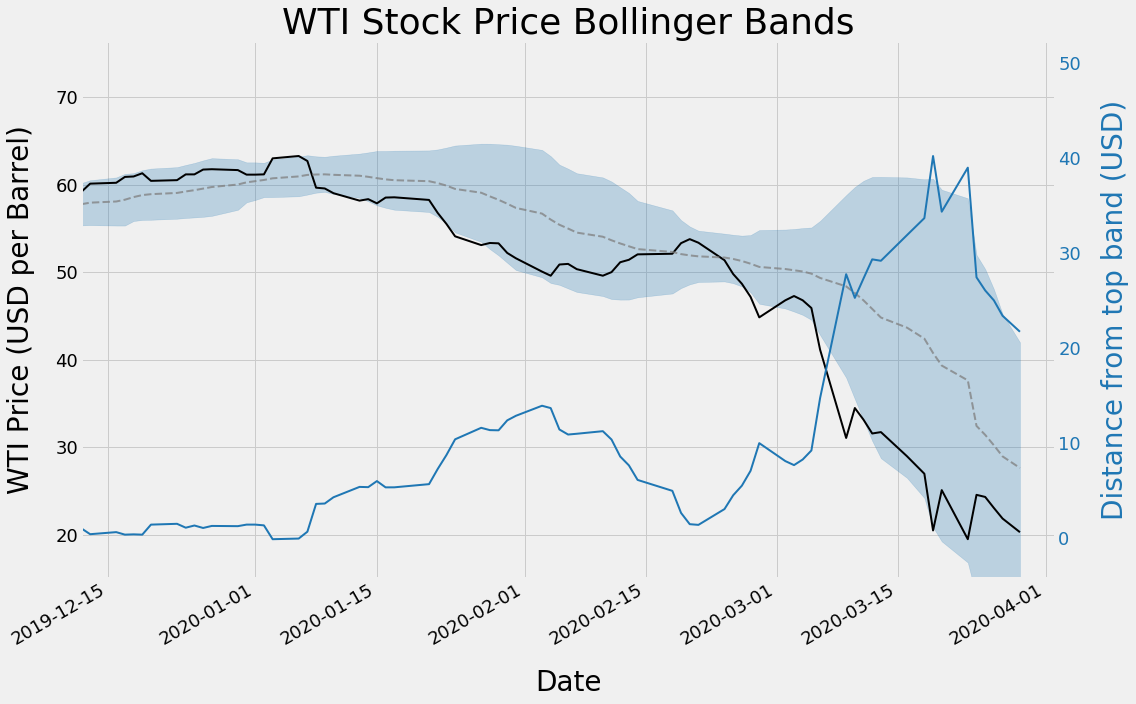

In [13]:
cols = df.columns
days = 75
dates = df["Date"][-days:].astype('O')
prices = df["Prices"][-days:]
upBand = df["boll_hi"][-days:]
lowBand = df["boll_lo"][-days:]
bollName = "20d Bollinger Bands"

plot2axis(x = pd.to_datetime(dates), y1 = prices, y_name = "WTI Price (USD per Barrel)", color1 = "black", lineax1 = True, lineax1y = df["20dSMA"][-days:], lineax1name = "20 Day SMA", axis2 = True, y2 = df["distFromTopBoll"][-days:], y2_name = "Distance from top band (USD)", fill_boll = True, bol_low = lowBand, bol_high = upBand, bol_name = bollName)


plt.title('WTI Stock Price Bollinger Bands', size = 36)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH+"featurePlots/", 'BollingerBands.png'), dpi = 300, bbox_inches = "tight")

In [14]:
df.columns

Index(['Date', 'Prices', 'OilProduction', 'NatGasPrices', 'BrentPrices',
       'SP500', 'Nasdaq', 'DowJones', 'Gold', 'Btc', 'Bond10y', '5dSMA',
       '10dSMA', '20dSMA', '50dSMA', '200dSMA', 'boll_lo', 'boll_hi',
       'Momentum_14', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26',
       'ROC_14', 'RSI_14', 'daysAbove5dSMA', 'daysAbove10dSMA',
       'daysAbove20dSMA', 'daysAbove50dSMA', 'daysAbove200dSMA',
       'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

Prices  OilProduction  NatGasPrices  BrentPrices  \
Prices            1.000000      -0.625840      0.572488     0.974734   
OilProduction    -0.625840       1.000000     -0.505005    -0.600419   
NatGasPrices      0.572488      -0.505005      1.000000     0.503551   
BrentPrices       0.974734      -0.600419      0.503551     1.000000   
SP500            -0.610900       0.966783     -0.496570    -0.588689   
Nasdaq           -0.610187       0.962877     -0.503882    -0.583417   
DowJones         -0.566452       0.954659     -0.477683    -0.538368   
Gold              0.469484      -0.276573     -0.091380     0.590879   
Bond10y           0.318992      -0.256084      0.607551     0.228807   
10dSMA            0.992548      -0.620275      0.572638     0.973205   
20dSMA            0.985653      -0.615300      0.570222     0.968719   
200dSMA           0.880397      -0.558975      0.526751     0.889744   
daysAbove200dSMA  0.444777      -0.161880      0.358947     0.401962   
distFromLowB

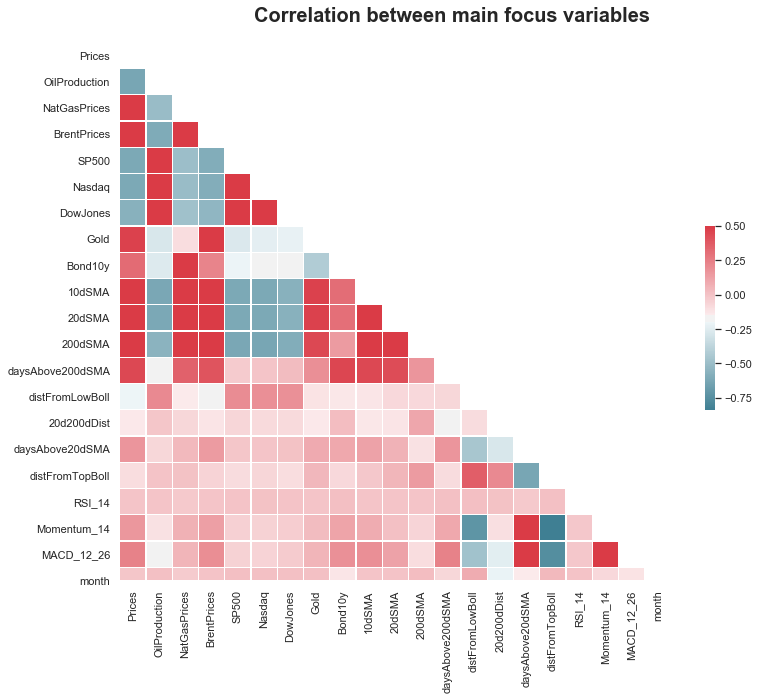

In [15]:
# Plot correlation matrix
sns.set(style="white")

focus_features = ['Prices', 'OilProduction', 'NatGasPrices', 'BrentPrices', 'SP500', 'Nasdaq', 'DowJones', 'Gold', 'Bond10y','10dSMA', '20dSMA', '200dSMA', 'daysAbove200dSMA', 'distFromLowBoll', '20d200dDist', 'daysAbove20dSMA', 'distFromTopBoll', 'RSI_14', 'Momentum_14', 'MACD_12_26', 'month']
nonShiftFeat = ['Prices','month']
dfCorr = copy.copy(df)

focus_cols=create_features(dfCorr, features = focus_features, shift = 1, nonShiftFeatures = nonShiftFeat)
corr = focus_cols.corr()

heat_fig, (ax)= plt.subplots(1, 1, figsize=(11,9))

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heat = sns.heatmap(corr, 
                   ax = (ax), 
                   mask = mask, 
                   vmax = .5, 
                   square = True, 
                   linewidths = .33,
                   cbar_kws = {"shrink": .33},
                   cmap = cmap)

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Correlation between main focus variables', fontsize=20, fontweight='bold')

plt.savefig('mainCorrelations.png', dpi=300, format='png');
print(corr)

In [30]:
newdf = copy.copy(focus_cols)
newdf = newdf[1:]
newdf[newdf.isna().any(axis=1)]
trainDataName = "modelInputData.csv"
newdf.to_csv(INPUT_PATH+trainDataName)


,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Bond10y,10dSMA,...,200dSMA,daysAbove200dSMA,distFromLowBoll,20d200dDist,daysAbove20dSMA,distFromTopBoll,RSI_14,Momentum_14,MACD_12_26,month
Date,,,,,,,,,,,,,,,,,,,,,


In [18]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


In [33]:
cols = newdf.columns.values

cols

array(['Prices', 'OilProduction', 'NatGasPrices', 'BrentPrices', 'SP500',
       'Nasdaq', 'DowJones', 'Gold', 'Bond10y', '10dSMA', '20dSMA',
       '200dSMA', 'daysAbove200dSMA', 'distFromLowBoll', '20d200dDist',
       'daysAbove20dSMA', 'distFromTopBoll', 'RSI_14', 'Momentum_14',
       'MACD_12_26', 'month'], dtype=object)

In [22]:
from dataLoader import DataLoader
from lstm import Model
import json

cols = newdf.columns.values
train_test_split = 0.9
rate = "Prices"

with open("config.json", "r") as jsonFile:
    conf = json.load(jsonFile)

tmp = conf["data"]["filename"]
conf["data"]["filename"] = INPUT_PATH+trainDataName
tmp2 = conf["data"]["columns"]
conf["data"]["columns"] = cols
tmp3 = conf["data"]["train_test_split"]
conf["data"]["train_test_split"] = train_test_split
tmp4 = conf["data"]["model"]["layers"][0]["input_dim"]
conf["data"]["model"]["layers"][0]["input_dim"] = len(cols)

with open("config.json", "w") as jsonFile:
    json.dump(data, jsonFile)

configs = json.load(open('config.json', "r"))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

data = DataLoader(
        INPUT_PATH+trainDataName,
        train_test_split,
        cols,
        rate)


model = Model()
model.build_model(configs)
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

sc = MinMaxScaler(feature_range=(0,1))

x = sc.fit_transform(focus_cols.values)
x
# x_train = sc.fit_transform(x)
# x_test = sc.transform(df_test.loc[:,feat])

# df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

# X_train, y_train = create_features(df_train,features,label='Prices', shift =1)
# X_test, y_test = create_features(df_test,label='Prices', shift =1)
# X_train = X_train.iloc[1:]
# X_test = X_test.iloc[1:]
# y_train = y_train.iloc[1:]
# y_test = y_test.iloc[1:]

array([[0.66063252,        nan,        nan, ...,        nan,        nan,
        0.        ],
       [0.66297519, 0.05288761, 0.69069069, ..., 0.79138737, 0.71966604,
        0.        ],
       [0.67767011, 0.05288761, 0.70570571, ..., 0.80357506, 0.74228028,
        0.        ],
       ...,
       [0.03801511, 0.98752651, 0.02642643, ..., 0.41763151, 0.07310702,
        0.18181818],
       [0.02513045, 0.98752651, 0.02237238, ..., 0.32256752, 0.09108188,
        0.18181818],
       [0.0085188 , 0.98752651, 0.01951952, ..., 0.32520821, 0.10326887,
        0.18181818]])

In [187]:
X = df[feat]
df_train[feat]
df_train[df_train.isna().any(axis=1)]
test = df_train.iloc[1:]

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Btc,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
1,2010-01-05,81.74,5507.0,6.19,79.27,1136.520020,2308.709961,10572.019531,1118.099976,NaN,...,0.961614,-14.965614,7.20645,1,1,1,2010,5,5,1
2,2010-01-06,83.12,5507.0,6.47,80.14,1137.140015,2301.090088,10573.679688,1135.900024,NaN,...,0.863697,-16.704697,7.51760,2,1,1,2010,6,6,1
3,2010-01-07,82.60,5507.0,7.51,80.57,1141.689941,2300.050049,10606.860352,1133.099976,NaN,...,2.384600,-16.184600,7.87190,3,1,1,2010,7,7,1
4,2010-01-08,82.74,5496.0,6.56,80.06,1144.979980,2317.169922,10618.190430,1138.199951,NaN,...,3.038614,-15.911614,8.32290,4,1,1,2010,8,8,1
5,2010-01-11,82.54,5496.0,5.77,80.14,1146.979980,2312.409912,10663.990234,1150.699951,NaN,...,3.821668,-15.094668,8.77955,0,1,1,2010,11,11,2
6,2010-01-12,80.79,5496.0,5.57,79.38,1136.219971,2282.310059,10627.259766,1128.900024,NaN,...,5.656388,-12.336388,9.18415,1,1,1,2010,12,12,2
7,2010-01-13,79.66,5496.0,5.61,77.57,1145.680054,2307.899902,10680.769531,1136.400024,NaN,...,6.514810,-9.916810,9.53730,2,1,1,2010,13,13,2
8,2010-01-14,79.35,5496.0,5.77,77.61,1148.459961,2316.739990,10710.549805,1142.599976,NaN,...,6.513130,-8.422130,9.82525,3,1,1,2010,14,14,2
9,2010-01-15,77.96,5404.0,5.66,76.85,1136.030029,2287.989990,10609.650391,1130.099976,NaN,...,7.668110,-6.265110,9.94375,4,1,1,2010,15,15,2
10,2010-01-19,78.98,5404.0,5.51,75.18,1150.229980,2320.399902,10725.429688,1139.699951,NaN,...,6.352690,-6.349690,10.13190,1,1,1,2010,19,19,3


In [191]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [192]:
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df.shape)
print(df.columns)
print(df.dtypes)
print("Train--Test size", len(df_train), len(df_test))

(2573, 40)
Index(['Date', 'Prices', 'OilProduction', 'NatGasPrices', 'BrentPrices',
       'SP500', 'Nasdaq', 'DowJones', 'Gold', 'Btc', 'Bond10y', '5dSMA',
       '10dSMA', '20dSMA', '50dSMA', '200dSMA', 'boll_lo', 'boll_hi',
       'Momentum_14', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26',
       'ROC_14', 'RSI_14', 'daysAbove5dSMA', 'daysAbove10dSMA',
       'daysAbove20dSMA', 'daysAbove50dSMA', 'daysAbove200dSMA',
       'bollAmplitude', 'distFromTopBoll', 'distFromLowBoll', '20d200dDist',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')
Date                datetime64[ns]
Prices                     float64
OilProduction              float64
NatGasPrices               float64
BrentPrices                float64
SP500                      float64
Nasdaq                     float64
DowJones                   float64
Gold                       float64
Btc                        float64
Bond10y                   

In [193]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
target_idx = 0
x_t, y_t = build_timeseries(x_train, target_idx)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 1998



length of time-series i/o (1998, 60, 1) (1998,)
Batch trimmed size (1980, 60, 1) (1980,)


In [195]:
x_temp, y_temp = build_timeseries(x_test, target_idx)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


dim_0 455



length of time-series i/o (455, 60, 1) (455,)
Test size (220, 60, 1) (220,) (220, 60, 1) (220,)


In [196]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

# model = Sequential()
# model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=100,batch_size=32)

In [197]:
model = None
try:
    model = pickle.load(open(modFileName, 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open(modFileName, "wb"))


Model not found
Building model...
checking if GPU available []

Train on 1980 samples, validate on 220 samples
Epoch 1/200
 - 5s - loss: 0.0076 - val_loss: 0.0113

Epoch 00001: val_loss improved from inf to 0.01130, saving model to /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/outputs/best_model.h5
Epoch 2/200
 - 6s - loss: 0.0081 - val_loss: 0.0118

Epoch 00002: val_loss did not improve from 0.01130
Epoch 3/200
 - 8s - loss: 0.0080 - val_loss: 0.0095

Epoch 00003: val_loss improved from 0.01130 to 0.00954, saving model to /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/outputs/best_model.h5
Epoch 4/200
 - 7s - loss: 0.0081 - val_loss: 0.0090

Epoch 00004: val_loss improved from 0.00954 to 0.00896, saving model to /Users/qw19176/Documents/Courses/codingChallenge/march2020/Team-Cpp/LSTM_dev/outputs/best_model.h5
Epoch 5/200
 - 6s - loss: 0.0083 - val_loss: 0.0094

Epoch 00005: val_loss did not improve from 0.00896
Epoch 6/200
 

In [198]:
# OUTPUT_PATH = "/Users/qw19176/Documents/Courses/Team-Cpp/"
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'LSTMRegressor' + '.log'), append=True)
# epochs = 100
# history = lstm_model.fit(x_t, y_t, epochs=epochs, verbose=2, batch_size=BATCH_SIZE,
#                     shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                     trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

In [199]:
# search_params = {
#     "batch_size": [20, 30, 40],
#     "time_steps": [30, 60, 90], 
#     "lr": [0.01, 0.001, 0.0001],
#     "epochs": [30, 50, 70]
# }

# def eval_model():
#     """
#     implement your logic to build a model, train it and then calculate validation loss.
#     Save this validation loss using CSVLogger of Keras or in a text file. Later you can
#     query to get the best combination.
#     """
#     pass

# def get_all_combinations(params):
#     all_names = params.keys()
#     combinations = it.product(*(params[name] for name in all_names))
#     return list(combinations)

# def run_search(mat, params):
#     param_combs = get_all_combinations(params) # list of tuples
#     logging.info("Total combinations to try = {}".format(len(param_combs)))
#     for i, combination in enumerate(param_combs):
#         logging.info("Trying combo no. {} {}".format(i, combination))
#         eval_model(mat, combination, i)

# run_search(x_input, search_params)

In [200]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.0008328164199322544 (220,) (220,)
[0.4405506  0.4500261  0.46143728 0.46282718 0.4541177  0.4377749
 0.4306307  0.43368357 0.43530452 0.423029   0.4149113  0.41586167
 0.41336873 0.41427004 0.41270748]
[0.45263761 0.45928899 0.45607798 0.44770642 0.42545872 0.4266055
 0.43165138 0.42844037 0.40779817 0.41043578 0.4141055  0.40389908
 0.41215596 0.40584862 0.40665138]


In [201]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[64.60601  65.432274 66.42733  66.54853  65.78906  64.36397  63.740997
 64.00721  64.14855  63.078125 62.370262 62.45314  62.235756 62.314346
 62.178093]
[65.66 66.24 65.96 65.23 63.29 63.39 63.83 63.55 61.75 61.98 62.3  61.41
 62.13 61.58 61.65]


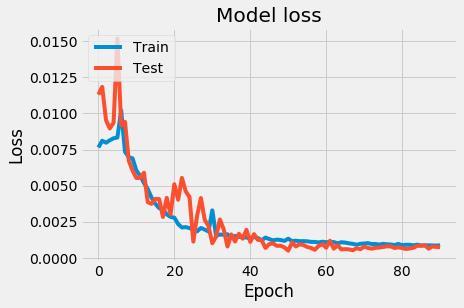

In [202]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [203]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [204]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.00038069078741959523 (220,) (220,)
[0.41924983 0.4250139  0.43565562 0.444428   0.44527712 0.4337123
 0.4208485  0.41351527 0.4108461  0.40669551 0.40250096 0.4000597
 0.3968584  0.3956723  0.39461255]
[0.45263761 0.45928899 0.45607798 0.44770642 0.42545872 0.4266055
 0.43165138 0.42844037 0.40779817 0.41043578 0.4141055  0.40389908
 0.41215596 0.40584862 0.40665138]
[62.74858  63.251213 64.17917  64.94412  65.018166 64.00971  62.887985
 62.248528 62.015778 61.653847 61.288086 61.075203 60.79605  60.692627
 60.600212]
[65.66 66.24 65.96 65.23 63.29 63.39 63.83 63.55 61.75 61.98 62.3  61.41
 62.13 61.58 61.65]


program completed  2445.0 minutes :  9.0 seconds


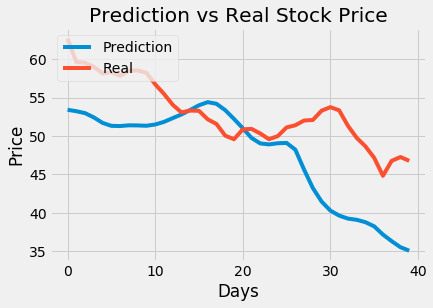

In [211]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[-40:])
plt.plot(y_test_t_org[-40:])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)

In [210]:
y_pred = saved_model.predict(trim_dataset(x_new_t,BATCH_SIZE), batch_size=BATCH_SIZE)
#y_pred = y_pred.flatten()
y_new_t = trim_dataset(y_new_t, BATCH_SIZE)
error = mean_squared_error(y_new_t, y_pred)
print("Mean squared error is", error, y_pred.shape, y_new_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
y_pred_org = (y_pred * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_pred)
y_new_t_org = (y_new_t * sc.data_range_[target_idx]) + sc.data_min_[target_idx] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[-40:])
print(y_new_t_org[-40:-23])

Mean squared error is 0.007572645727495178 (40, 1) (40,)
[[53.43094 ]
 [53.242504]
 [52.99154 ]
 [52.433952]
 [51.72047 ]
 [51.335686]
 [51.307777]
 [51.40619 ]
 [51.390022]
 [51.34562 ]
 [51.507584]
 [51.84755 ]
 [52.33808 ]
 [52.82045 ]
 [53.402596]
 [54.015335]
 [54.424534]
 [54.210526]
 [53.380302]
 [52.23773 ]
 [51.03424 ]
 [49.75766 ]
 [49.042946]
 [48.91981 ]
 [49.068195]
 [49.109398]
 [48.2347  ]
 [45.63312 ]
 [43.233746]
 [41.47133 ]
 [40.294712]
 [39.644913]
 [39.2515  ]
 [39.09395 ]
 [38.78594 ]
 [38.243347]
 [37.173058]
 [36.310356]
 [35.52468 ]
 [35.06858 ]]
[52.19 51.58 50.06 49.59 50.87 50.94 50.34 49.59 50.   51.13 51.41 52.03
 52.1  53.31 53.77 53.36 51.36]


In [207]:
to_pred = df["Prices"][-139:].values
to_pred = np.append(to_pred,50)
# trim_dataset(x_test_t, BATCH_SIZE)
to_pred = sc.transform(to_pred.reshape(-1,1))
x_new, y_new = build_timeseries(to_pred, target_idx)
x_newval, x_new_t = np.split(trim_dataset(x_new,BATCH_SIZE),2)
y_newval, y_new_t = np.split(trim_dataset(y_new,BATCH_SIZE),2)
to_pred.shape
# print("Test size", x_new_t.shape, y_new_t.shape, x_newval.shape, y_newval.shape)

dim_0 80



length of time-series i/o (80, 60, 1) (80,)


(140, 1)

In [208]:
df["Prices"][-61:]

2512    61.660000
2513    61.140000
2514    61.140000
2515    61.170000
2516    63.000000
          ...    
2568    27.330000
2569    20.830000
2570    25.910000
2571    21.540001
2572    24.450001
Name: Prices, Length: 61, dtype: float64

In [209]:
df.tail(5)

,Date,Prices,OilProduction,NatGasPrices,BrentPrices,SP500,Nasdaq,DowJones,Gold,Btc,...,distFromTopBoll,distFromLowBoll,20d200dDist,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2568,2020-03-18,27.330000,13100.0,1.729,27.639999,2398.100098,6989.839844,19898.919922,1525.800049,5238.438477,...,23.561638,-5.293638,17.70190,2,1,3,2020,78,18,12
2569,2020-03-19,20.830000,13100.0,1.604,28.590000,2409.389893,7150.580078,20087.189453,1477.900024,6191.192871,...,29.422651,-0.788650,18.85655,3,1,3,2020,79,19,12
2570,2020-03-20,25.910000,13100.0,1.654,27.410000,2304.919922,6879.520020,19173.980469,1479.300049,6198.778320,...,23.211996,-6.629996,19.67645,4,1,3,2020,80,20,12
2571,2020-03-22,21.540001,13100.0,1.537,25.100000,2304.919922,6879.520020,19173.980469,1495.599976,5830.254883,...,26.108383,-3.310385,20.78425,6,1,3,2020,82,22,12
2572,2020-03-23,24.450001,13100.0,1.604,27.750000,2237.399902,6860.669922,18591.929688,1575.699951,6416.314941,...,20.869026,-6.173028,21.78515,0,1,3,2020,83,23,13


In [ ]:
"""
TALOS OPTIMISATION

NOT IMPLEMENTED YET
"""

def data(search_params):
    """
    The function that prepares the data for LSTM training specific to this problem as per values in search_params.
    """
    global mat

    BATCH_SIZE = search_params["batch_size"]
    TIME_STEPS = search_params["time_steps"]
    x_train, x_test = train_test_split(mat, train_size=0.8, test_size=0.2, shuffle=False)

    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.transform(x_test)

    x_train_ts, y_train_ts = build_timeseries(x_train, 3, TIME_STEPS)
    x_test_ts, y_test_ts = build_timeseries(x_test, 3, TIME_STEPS)
    x_train_ts = trim_dataset(x_train_ts, BATCH_SIZE)
    y_train_ts = trim_dataset(y_train_ts, BATCH_SIZE)
    x_test_ts = trim_dataset(x_test_ts, BATCH_SIZE)
    y_test_ts = trim_dataset(y_test_ts, BATCH_SIZE)
    print("Test size(trimmed) {}, {}".format(x_test_ts.shape, y_test_ts.shape))
    return x_train_ts, y_train_ts, x_test_ts, y_test_ts
  
  def create_model_talos(x_train_ts, y_train_ts, x_test_ts, y_test_ts, params):
    """
    function that builds model, trains, evaluates on validation data and returns Keras history object and model for
    talos scanning. Here I am creating data inside function because data preparation varies as per the selected value of 
    batch_size and time_steps during searching. So we ignore data that's received here as argument from scan method of Talos.
    """
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = data(params)
    BATCH_SIZE = params["batch_size"]
    TIME_STEPS = params["time_steps"]
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train_ts.shape[2]), dropout=0.2,
                        recurrent_dropout=0.2, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    if params["lstm_layers"] == 2:
        lstm_model.add(LSTM(params["lstm2_nodes"], dropout=0.2))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"] == 2:
        lstm_model.add(Dense(params["dense2_nodes"], activation='relu'))

    lstm_model.add(Dense(1, activation='sigmoid'))
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    else:
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                             validation_data=[x_test_ts, y_test_ts],
                             callbacks=[LogMetrics(search_params, params, -1), csv_logger])
    return history, lstm_model
  
print("Starting Talos scanning...")
t = ta.Scan(x=mat, # data parameter is ignored in this example as here data varies based on batch_size & time_steps
            y=mat[:,0], # dummy data just to avoid errors. input and output calculated in create_model_talos
            model=create_model_talos,
            params=search_params,
            dataset_name='stock_ge',
            experiment_no='1',
            reduction_interval=10)

pickle.dump(t, open(os.path.join(OUTPUT_PATH,"talos_res"),"wb"))